# Enrichment Analysis

In [1]:
import pandas as pd
input_file = "/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/samples_features_means_updated.csv"
df = pd.read_csv(input_file)

In [2]:
df.head()

,filename,label,batch,group,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_1272,feature_1273,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279,area,gene
0,clean_0_190605_6.csv,0,190605,6,0.004680,0.003580,0.005346,0.004071,0.003700,0.003822,...,0.002469,0.006853,0.005932,0.008330,0.005137,0.007786,0.054964,0.007108,517.579569,NaN
1,clean_0_181213_4.csv,0,181213,4,0.008239,0.006134,0.007640,0.006977,0.005644,0.006286,...,0.006022,0.008585,0.008980,0.009454,0.007856,0.010355,0.024081,0.008710,529.769561,NaN
2,clean_0_190531_5.csv,0,190531,5,0.003652,0.003205,0.004977,0.002953,0.003008,0.003719,...,0.001358,0.006598,0.004782,0.008488,0.004313,0.007184,0.059204,0.006139,470.877564,NaN
3,clean_1_190425_98.csv,1,190425,98,0.007931,0.006726,0.007014,0.005729,0.005405,0.005937,...,0.006717,0.007806,0.008593,0.009071,0.008033,0.009215,-0.050986,0.006979,540.172380,yghR
4,clean_0_190423_1.csv,0,190423,1,0.007629,0.006392,0.006733,0.005575,0.005297,0.005582,...,0.006200,0.007702,0.007991,0.009057,0.007849,0.009064,-0.039573,0.006921,524.914474,NaN


### Standardization 

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select numeric columns for clustering, excluding metadata
numeric_columns = [col for col in df.columns if col not in ['label', 'batch', 'group', 'filename', 'gene']]

# Extract features for clustering
X = df[numeric_columns].values

# Standardize the features (zero mean, unit variance)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Clustering K-Means

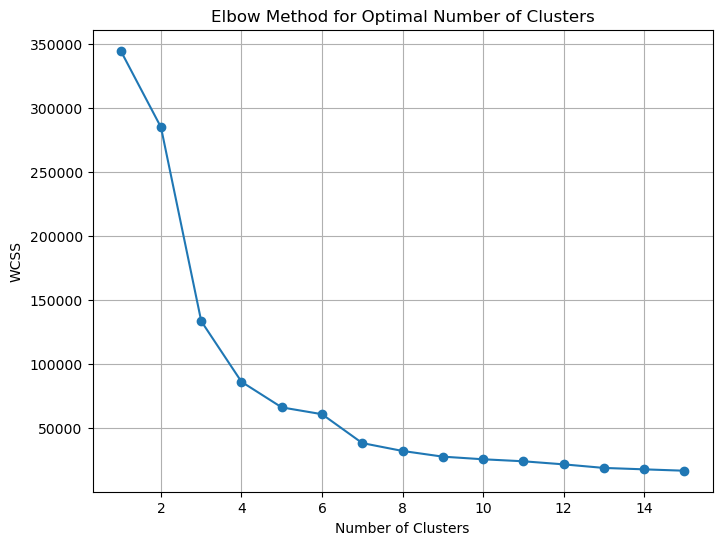

In [4]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform the elbow method to determine the optimal number of clusters
wcss = []
max_clusters = 15  # Adjust the range of clusters to test
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-', color='#1f77b4')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [5]:
# Choose the optimal number of clusters based on the elbow plot (manual inspection)
n_clusters = 7  # Replace with the number you determine from the plot

# Perform K-means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original DataFrame
df['k-means'] = cluster_labels

In [6]:
# Retrieve and print gene names for each cluster
unique_clusters = df['k-means'].unique()
print("GENE NAMES PER CLUSTER:")
for cluster in unique_clusters:
    cluster_mask = df['k-means'] == cluster
    cluster_genes = df[cluster_mask]['gene'].dropna().unique()
    print(f"Cluster {cluster}: {', '.join(cluster_genes) if len(cluster_genes) > 0 else 'No genes found'}")

# Save gene names per cluster to a CSV file
cluster_gene_df = df[['k-means', 'gene']].dropna().groupby('k-means')['gene'].apply(lambda x: ', '.join(x.unique())).reset_index()
output_file = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/kmeans_cluster_genes.csv'
cluster_gene_df.to_csv(output_file, index=False)
print(f"\nCluster gene assignments saved to {output_file}")

GENE NAMES PER CLUSTER:
Cluster 3: No genes found
Cluster 0: yghR, stpA, ypfN, yaiA, gspA, truC, yddK, fepC, yciT, wecD, rppH, yfdM, yfdQ, opgC, sufB, ygbF, hslU, yebG, atpE, hupA, hiuH, citG, yagM, agaR, xdhD, ybeM, yhgN, ytjB, mnmC, eutQ, hicA, eutN, ypdF, rcnB, bglG, ydjX, hchA, ychO, yraI, hicB, yjbE, hyfR, pncA, ompR, ygjK, dcuC, ycjU, treB, yjcE, mlaE, sspA, arnE, sdiA, yibN, yihN, qorB, lrp, yjbI, yfjK, torR, yhdU, metJ, fucR
Cluster 4: sstT, ybbD, msrC, wbbL, iscR, eamB, ugpQ, aceF, ybhK, yfbP, ruvB, frc, yedK, ydjA, ybeL, yafO, cybC, yciM, dedD, ybgC, rnlA, dusC, iscA, yciE, ydgD, yfbV, ptrB, yniA, anmK, ybdH, nrdF, yacL, yneJ
Cluster 5: yebF, gcvA, tusB
Cluster 1: ycgV, ygeG
Cluster 6: damX, menB, ykgJ, mtgA, rep, sucB
Cluster 2: No genes found

Cluster gene assignments saved to /scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/kmeans_cluster_genes.csv


## Gaussian Mixture model

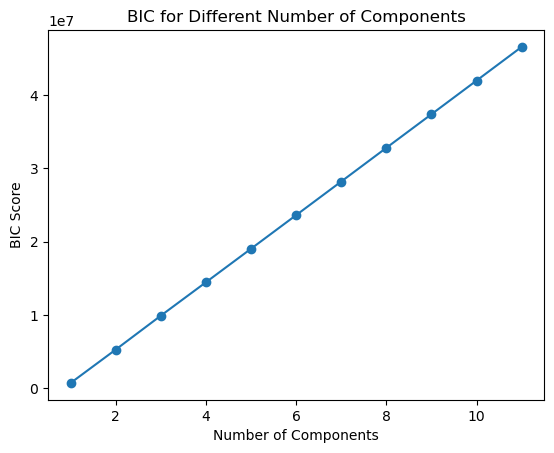

In [7]:
from sklearn.mixture import GaussianMixture

n_components_range = range(1, 12)  # Adjust range as needed
bic = []
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_scaled)
    bic.append(gmm.bic(X_scaled))

# Plot BIC to choose number of components
plt.plot(n_components_range, bic, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC for Different Number of Components')
plt.show()

In [8]:
# Choose the optimal number of components based on the BIC plot (manual inspection)
n_components = 7  # Replace with the number you determine from the plot

# Perform GMM clustering with the chosen number of components
gmm = GaussianMixture(n_components=n_components, random_state=42)
cluster_labels = gmm.fit_predict(X_scaled)

# Add cluster labels to the original DataFrame
df['gaussian'] = cluster_labels

In [9]:
# Retrieve and print gene names for each cluster
unique_clusters = df.gaussian.unique()
print("GENE NAMES PER CLUSTER:")
for cluster in unique_clusters:
    cluster_mask = df['gaussian'] == cluster
    cluster_genes = df[cluster_mask]['gene'].dropna().unique()
    print(f"Cluster {cluster}: {', '.join(cluster_genes) if len(cluster_genes) > 0 else 'No genes found'}")

# Save gene names per cluster to a CSV file
cluster_gene_df = df[['gaussian', 'gene']].dropna().groupby('gaussian')['gene'].apply(lambda x: ', '.join(x.unique())).reset_index()
output_file = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/gmm_cluster_genes.csv'
cluster_gene_df.to_csv(output_file, index=False)
print(f"\nCluster gene assignments saved to {output_file}")

GENE NAMES PER CLUSTER:
Cluster 3: No genes found
Cluster 0: yghR, stpA, ypfN, yaiA, gspA, truC, yddK, fepC, yciT, wecD, rppH, yfdM, yfdQ, opgC, sufB, ygbF, hslU, yebG, atpE, hupA, hiuH, citG, yagM, agaR, xdhD, ybeM, yhgN, ytjB, mnmC, eutQ, hicA, eutN, ypdF, rcnB, bglG, ydjX, hchA, ychO, yraI, hicB, yjbE, hyfR, pncA, ompR, ygjK, dcuC, ycjU, treB, yjcE, mlaE, sspA, arnE, sdiA, yibN, yihN, qorB, lrp, yjbI, yfjK, torR, yhdU, metJ, fucR
Cluster 4: sstT, ybbD, msrC, wbbL, iscR, eamB, ugpQ, aceF, ybhK, yfbP, ruvB, frc, yedK, ydjA, ybeL, yafO, cybC, yciM, dedD, ybgC, rnlA, dusC, iscA, yciE, ydgD, yfbV, ptrB, yniA, anmK, ybdH, nrdF, yacL, yneJ
Cluster 5: yebF, gcvA, tusB
Cluster 1: ycgV, ygeG
Cluster 6: damX, menB, ykgJ, mtgA, rep, sucB
Cluster 2: No genes found

Cluster gene assignments saved to /scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/gmm_cluster_genes.csv


### HDBSCAN

In [10]:
import hdbscan
import pandas as pd
import numpy as np

# Perform HDBSCAN clustering
hdb = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5, cluster_selection_method='eom')
cluster_labels = hdb.fit_predict(X_scaled)

# Add cluster labels to the original DataFrame
df['hdbscan'] = cluster_labels

In [11]:
# Calculate the percentage of -1 (noise) labels
noise_count = (df['hdbscan'] == -1).sum()  # Count of -1 labels
total_samples = len(df['hdbscan'])  # Total number of samples
noise_percentage = (noise_count / total_samples) * 100

print(f"Percentage of samples labeled as noise (-1): {noise_percentage:.2f}%")

Percentage of samples labeled as noise (-1): 45.35%


In [12]:
unique_clusters = df.hdbscan.unique()

# Retrieve and print gene names for each cluster
print("\nGene names per cluster:")
for cluster in sorted(unique_clusters):
    cluster_mask = df['hdbscan'] == cluster
    cluster_genes = df[cluster_mask]['gene'].dropna().unique()
    print(f"Cluster {cluster}: {', '.join(cluster_genes) if len(cluster_genes) > 0 else 'No genes found'}")

# Save gene names per cluster to a CSV file
cluster_gene_df = df[['hdbscan', 'gene']].dropna().groupby('hdbscan')['gene'].apply(lambda x: ', '.join(x.unique())).reset_index()
output_file = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/hdbscan_cluster_genes.csv'
cluster_gene_df.to_csv(output_file, index=False)
print(f"Cluster gene assignments saved to {output_file}")


Gene names per cluster:
Cluster -1: sstT, ycgV, msrC, ypfN, yaiA, damX, eamB, yciT, yfdM, ugpQ, yfdQ, menB, opgC, ykgJ, aceF, hslU, yfbP, yedK, hupA, citG, yagM, mtgA, xdhD, rep, yebF, mnmC, eutQ, hicA, eutN, ypdF, cybC, yciM, hicB, ygeG, hyfR, sucB, sspA, ydgD, tusB, sdiA, lrp, nrdF, yacL, yneJ
Cluster 0: ybhK, dusC
Cluster 1: ybbD, wbbL, iscR, ruvB, frc, ydjA, ybeL, yafO, dedD, ybgC, rnlA, iscA, yciE, yfbV, ptrB, yniA, anmK, ybdH
Cluster 2: No genes found
Cluster 3: gcvA
Cluster 4: No genes found
Cluster 5: yghR, stpA, gspA, truC, yddK, fepC, wecD, rppH, sufB, ygbF, yebG, atpE, hiuH, agaR, ybeM, yhgN, ytjB, rcnB, bglG, ydjX, hchA, ychO, yraI, yjbE, pncA, ompR, ygjK, dcuC, ycjU, treB, yjcE, mlaE, arnE, yibN, yihN, qorB, yjbI, yfjK, torR, yhdU, metJ, fucR
Cluster gene assignments saved to /scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/hdbscan_cluster_genes.csv


### Perform PCA

In [13]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select numeric columns for PCA, excluding metadata
numeric_columns = [col for col in df.columns if col not in ['label', 'batch', 'group', 'filename', 'gene', 'k-means', 'gaussian', 'hdbscan']]

# Extract features for PCA
X = df[numeric_columns].values

# Standardize the features (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['label'] = df['label'].values
pca_df['batch'] = df['batch'].values
pca_df['group'] = df['group'].values
pca_df['gene'] = df['gene'].values
pca_df['filename'] = df['filename'].values
pca_df['k-means'] = df['k-means'].values
pca_df['gaussian'] = df['gaussian'].values
pca_df['hdbscan'] = df['hdbscan'].values

In [15]:
def plot_clusters_pca(pca_df, cluster_col, pca, output_path, figsize=(10, 8), alpha=0.6, point_size=50):
    """
    Plot clusters on PCA results with gene annotations for mutants.
    
    Parameters:
    - pca_df: DataFrame with columns 'PC1', 'PC2', 'cluster', 'label', and 'gene'
    - pca: PCA object from sklearn.decomposition.PCA
    - output_path: str, path to save the plot
    - figsize: tuple, figure size (width, height)
    - alpha: float, transparency of scatter points
    - point_size: int, size of scatter points
    """
    plt.figure(figsize=figsize)
    unique_clusters = sorted(pca_df[cluster_col].unique())
    colors = plt.colormaps.get_cmap('tab10')

    # Plot each cluster
    for cluster in unique_clusters:
        mask = pca_df[cluster_col] == cluster
        plt.scatter(
            pca_df[mask]['PC1'],
            pca_df[mask]['PC2'],
            label=f'Cluster {cluster}',
            color=colors(cluster),
            alpha=alpha,
            s=point_size
        )

    # Add gene annotations for mutants (label == 1)
    # mutant_mask = pca_df['label'] == 1
    # for idx, row in pca_df[mutant_mask].iterrows():
    #     if pd.notna(row['gene']):
    #         plt.annotate(
    #             row['gene'],
    #             (row['PC1'], row['PC2']),
    #             xytext=(7, 7),
    #             textcoords='offset points',
    #             fontsize=7,
    #             color='black',
    #             bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray', boxstyle='round,pad=0.3')
    #         )

    # Add plot details
    plt.title(f'{cluster_col} Clustering on PCA of Sample Feature Means')
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend(title='Cluster')
    plt.grid(True)

    # Save the plot
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()  # Close the figure to prevent display in non-interactive environments
    
    print(f"Clustering plot saved to {output_path}")

In [17]:
plot_clusters_pca(pca_df, 'k-means', pca, '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/kmeans_pca_plot_no_text.png', figsize=(10, 8), alpha=0.6, point_size=50)

Clustering plot saved to /scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/kmeans_pca_plot_no_text.png


In [18]:
plot_clusters_pca(pca_df,'hdbscan', pca, '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/hdbscan_pca_plot_no_text.png', figsize=(10, 8), alpha=0.6, point_size=50)

Clustering plot saved to /scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/hdbscan_pca_plot_no_text.png


In [19]:
plot_clusters_pca(pca_df,'gaussian',  pca, '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/gaussian_pca_plot_no_text.png', figsize=(10, 8), alpha=0.6, point_size=50)

Clustering plot saved to /scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/gaussian_pca_plot_no_text.png


In [16]:
plot_clusters_pca(pca_df,'label',  pca, '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/label_pca_plot_no_text.png', figsize=(10, 8), alpha=0.6, point_size=50)

Clustering plot saved to /scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/label_pca_plot_no_text.png


## t-SNE

In [12]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select numeric columns for t-SNE, excluding metadata
numeric_columns = [col for col in df.columns if col not in ['label', 'batch', 'group', 'filename', 'gene', 'k-means', 'gaussian', 'hdbscan']]

# Extract features for t-SNE
X = df[numeric_columns].values

# Standardize the features (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE to reduce to 2 components
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = df['label'].values
tsne_df['batch'] = df['batch'].values
tsne_df['group'] = df['group'].values
tsne_df['gene'] = df['gene'].values
tsne_df['filename'] = df['filename'].values
tsne_df['k-means'] = df['k-means'].values
tsne_df['gaussian'] = df['gaussian'].values
tsne_df['hdbscan'] = df['hdbscan'].values

In [13]:
def plot_clusters_tsne(tsne_df, cluster_col, output_path, figsize=(10, 8), alpha=0.6, point_size=50):
    """
    Plot clusters on t-SNE results with gene annotations for mutants.
    
    Parameters:
    - tsne_df: DataFrame with columns 'TSNE1', 'TSNE2', 'cluster', 'label', and 'gene'
    - cluster_col: str, column name containing cluster labels
    - output_path: str, path to save the plot
    - figsize: tuple, figure size (width, height)
    - alpha: float, transparency of scatter points
    - point_size: int, size of scatter points
    """
    plt.figure(figsize=figsize)
    unique_clusters = sorted(tsne_df[cluster_col].unique())
    colors = plt.colormaps.get_cmap('tab10')

    # Define legend labels, handling HDBSCAN noise points
    label_names = {cluster: f'Cluster {cluster}' for cluster in unique_clusters}
    if -1 in unique_clusters:
        label_names[-1] = 'Noise'

    # Plot each cluster
    for cluster in unique_clusters:
        mask = tsne_df[cluster_col] == cluster
        plt.scatter(
            tsne_df[mask]['TSNE1'],
            tsne_df[mask]['TSNE2'],
            label=label_names.get(cluster, f'Cluster {cluster}'),
            color=colors((cluster + 1) / len(unique_clusters) if cluster != -1 else 0.0),
            alpha=alpha,
            s=point_size
        )

    # Add gene annotations for mutants (label == 1)
    mutant_mask = tsne_df['label'] == 1
    for idx, row in tsne_df[mutant_mask].iterrows():
        if pd.notna(row['gene']):
            plt.annotate(
                row['gene'],
                (row['TSNE1'], row['TSNE2']),
                xytext=(7, 7),
                textcoords='offset points',
                fontsize=7,
                color='black',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray', boxstyle='round,pad=0.3')
            )

    # Add plot details
    plt.title(f'{cluster_col} Clustering on t-SNE of Sample Feature Means')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Cluster')
    plt.grid(True)

    # Save the plot
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()  # Close the figure to prevent display in non-interactive environments
    
    print(f"t-SNE clustering plot saved to {output_path}")

In [ ]:
# Plot t-SNE results for K-Means, HDBSCAN, Gaussian, and Label
plot_clusters_tsne(tsne_df, 'k-means', '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/kmeans_tsne_plot.png', figsize=(10, 8), alpha=0.6, point_size=50)
plot_clusters_tsne(tsne_df, 'hdbscan', '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/hdbscan_tsne_plot.png', figsize=(10, 8), alpha=0.6, point_size=50)
plot_clusters_tsne(tsne_df, 'gaussian', '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/gaussian_tsne_plot.png', figsize=(10, 8), alpha=0.6, point_size=50)
plot_clusters_tsne(tsne_df, 'label', '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/label_tsne_plot.png', figsize=(10, 8), alpha=0.6, point_size=50)

In [14]:
plot_clusters_tsne(tsne_df, 'k-means', '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/kmeans_tsne_plot.png', figsize=(10, 8), alpha=0.6, point_size=50)

t-SNE clustering plot saved to /scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/kmeans_tsne_plot.png


In [15]:
plot_clusters_tsne(tsne_df, 'gaussian', '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/gaussian_tsne_plot.png', figsize=(10, 8), alpha=0.6, point_size=50)

t-SNE clustering plot saved to /scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/gaussian_tsne_plot.png


### UMAP

In [ ]:
import pandas as pd
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select numeric columns for UMAP, excluding metadata
numeric_columns = [col for col in df.columns if col not in ['label', 'batch', 'group', 'filename', 'gene', 'k-means', 'gaussian', 'hdbscan']]

# Extract features for UMAP
X = df[numeric_columns].values

# Standardize the features (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP to reduce to 2 components
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# Create a DataFrame with UMAP results
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
umap_df['label'] = df['label'].values
umap_df['batch'] = df['batch'].values
umap_df['group'] = df['group'].values
umap_df['gene'] = df['gene'].values
umap_df['filename'] = df['filename'].values
umap_df['k-means'] = df['k-means'].values
umap_df['gaussian'] = df['gaussian'].values
umap_df['hdbscan'] = df['hdbscan'].values

In [ ]:
def plot_clusters_umap(umap_df, cluster_col, output_path, figsize=(10, 8), alpha=0.6, point_size=50):
    """
    Plot clusters on UMAP results with gene annotations for mutants.
    
    Parameters:
    - umap_df: DataFrame with columns 'UMAP1', 'UMAP2', 'cluster', 'label', and 'gene'
    - cluster_col: str, column name containing cluster labels
    - output_path: str, path to save the plot
    - figsize: tuple, figure size (width, height)
    - alpha: float, transparency of scatter points
    - point_size: int, size of scatter points
    """
    plt.figure(figsize=figsize)
    unique_clusters = sorted(umap_df[cluster_col].unique())
    colors = plt.colormaps.get_cmap('tab10')

    # Define legend labels, handling HDBSCAN noise points
    label_names = {cluster: f'Cluster {cluster}' for cluster in unique_clusters}
    if -1 in unique_clusters:
        label_names[-1] = 'Noise'

    # Plot each cluster
    for cluster in unique_clusters:
        mask = umap_df[cluster_col] == cluster
        plt.scatter(
            umap_df[mask]['UMAP1'],
            umap_df[mask]['UMAP2'],
            label=label_names.get(cluster, f'Cluster {cluster}'),
            color=colors((cluster + 1) / len(unique_clusters) if cluster != -1 else 0.0),
            alpha=alpha,
            s=point_size
        )

    # Add gene annotations for mutants (label == 1)
    mutant_mask = umap_df['label'] == 1
    for idx, row in umap_df[mutant_mask].iterrows():
        if pd.notna(row['gene']):
            plt.annotate(
                row['gene'],
                (row['UMAP1'], row['UMAP2']),
                xytext=(7, 7),
                textcoords='offset points',
                fontsize=7,
                color='black',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray', boxstyle='round,pad=0.3')
            )

    # Add plot details
    plt.title(f'{cluster_col} Clustering on UMAP of Sample Feature Means')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend(title='Cluster')
    plt.grid(True)

    # Save the plot
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()  # Close the figure to prevent display in non-interactive environments
    
    print(f"UMAP clustering plot saved to {output_path}")

In [ ]:
# Plot UMAP results for K-Means, HDBSCAN, Gaussian, and Label
plot_clusters_umap(umap_df, 'k-means', '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/kmeans_umap_plot.png', figsize=(10, 8), alpha=0.6, point_size=50)
plot_clusters_umap(umap_df, 'hdbscan', '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/hdbscan_umap_plot.png', figsize=(10, 8), alpha=0.6, point_size=50)
plot_clusters_umap(umap_df, 'gaussian', '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/gaussian_umap_plot.png', figsize=(10, 8), alpha=0.6, point_size=50)
plot_clusters_umap(umap_df, 'label', '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/label_umap_plot.png', figsize=(10, 8), alpha=0.6, point_size=50)